# Comparison among numpy, numexpr, and numba

In [26]:
import numpy as np
import numexpr as ne
import pandas as pd
from numba import jit
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display_html

In [2]:
# Timing function (using timeit module does not provide relaible performances)
def test_time(func):
    trial_range = list(map(lambda x: int(np.power(10, x)), range(2, 8)))
    ret_dict = {}
    number = 50 # make 50 tests
    for trials in tqdm(trial_range):
        times = []
        for i in tqdm(range(number)):
            start = time.time()
            func(trials)
            stop = time.time()
            times.append(stop-start)
        ret_dict[trials] = times
    return ret_dict

## Test numpy

In [3]:
def Hist_numpy(trials: int) -> np.array:

   # Vectorized version, much faster (Annual interest from 40% to 70% random normal)
    distribution = 1 + np.random.normal(0.4, 0.7, (12, trials)) / 12
    interest = np.array([range(12, 0, -1)]).T
    res = (10 * np.power(distribution,interest)).sum(axis=0)
    
    return res

In [4]:
numpy_timing = test_time(Hist_numpy)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
# Get mean and std for each set of iterations
df = pd.DataFrame(numpy_timing)
numpy_df = pd.concat([pd.Series(df.mean(), name="numpy_mean"), pd.Series(df.std(), name="numpy_std")],axis=1)

## Test numexpr

In [8]:
# Helper function that creates distribution and statistics
def Hist_numexpr(trials: int) -> np.array:

    # Vectorized version, much faster (Annual interest from 40% to 70% random normal)
    distribution = 1 + np.random.normal(0.4, 0.7, (12, trials)) / 12
    interest = np.array([range(12, 0, -1)]).T
    res = ne.evaluate("sum(10*(distribution**interest),axis=0)")

    return res

In [9]:
numexpr_timing = test_time(Hist_numexpr)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
df = pd.DataFrame(numexpr_timing)
numexpr_df = pd.concat([pd.Series(df.mean(), name="numexpr_mean"), pd.Series(df.std(), name="numexpr_std")],axis=1)

## Test numba

In [11]:
@jit(nopython=True,parallel=True) # Set "nopython" mode for best performance, equivalent to @njit
def Hist_numba(trials):

    # Vectorized version, much faster (Annual interest from 40% to 70% random normal)
    distribution = 1 + np.random.normal(0.4, 0.7, (12, trials)) / 12
    interest = np.arange(12, 0, -1).reshape(-1,1)
    res = (10 * np.power(distribution,interest)).sum(axis=0)

    return res

In [12]:
numba_timing = test_time(Hist_numba)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
df = pd.DataFrame(numba_timing)
numba_df = pd.concat([pd.Series(df.mean(), name="numba_mean"), pd.Series(df.std(), name="numba_std")],axis=1)

## Plot results

In [16]:
df = pd.concat([numpy_df, numexpr_df,numba_df], axis=1)
# Add difference between NumExpr and Numba
df["Delta"] = df.numexpr_mean-df.numba_mean
df["Delta %"] = (df.Delta/df.numexpr_mean)*100

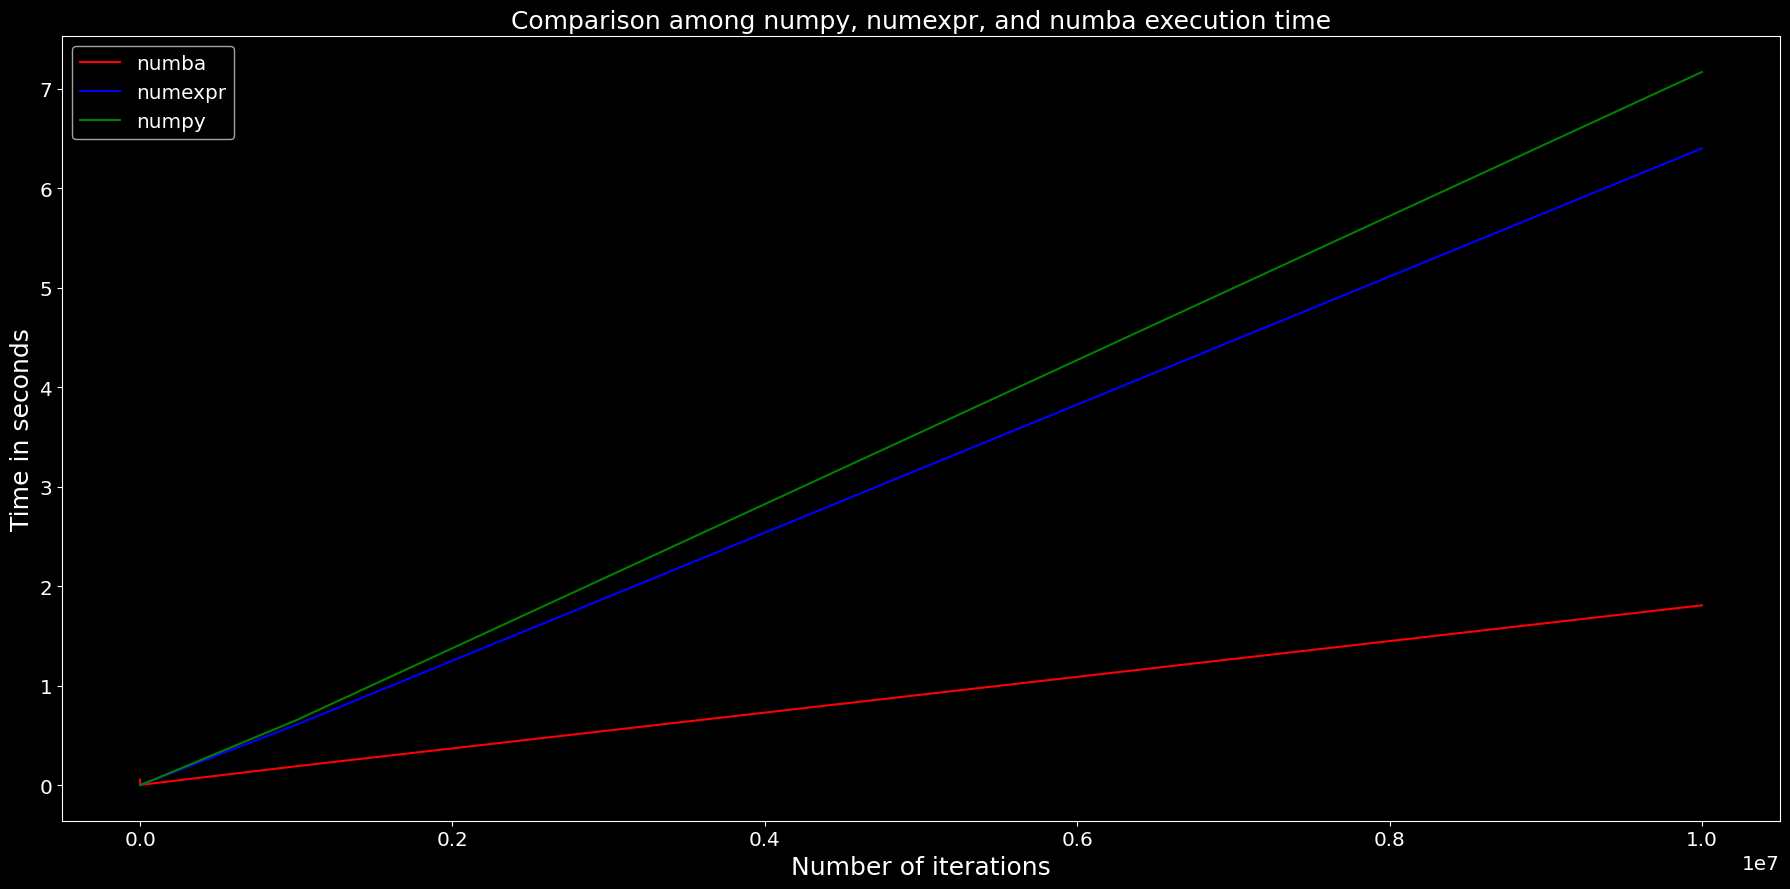

In [34]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('dark_background')
plt.plot(df.numba_mean, c="r", label="numba")
plt.plot(df.numexpr_mean, c="b", label="numexpr")
plt.plot(df.numpy_mean, c="g", label="numpy")
plt.title("Comparison among numpy, numexpr, and numba execution time", fontdict={"fontsize":18})
plt.xlabel("Number of iterations", fontdict={"fontsize":18})
plt.ylabel("Time in seconds", fontdict={"fontsize":18})
plt.legend()
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()

In [33]:
# Export dadatframe
table = df.to_html()
display_html(table, raw=True)

,numpy_mean,numpy_std,numexpr_mean,numexpr_std,numba_mean,numba_std,Delta,Delta %
100,0.000161,0.000135,0.000190,0.000153,0.054950,0.387602,-0.054760,-28892.283888
1000,0.000703,0.000127,0.000687,0.000076,0.000407,0.000126,0.000280,40.772931
10000,0.006341,0.000231,0.006060,0.000046,0.002381,0.000382,0.003679,60.712667
100000,0.063277,0.001100,0.060028,0.001089,0.020787,0.001920,0.039241,65.370916
1000000,0.652204,0.008045,0.606476,0.002097,0.189293,0.018253,0.417183,68.788008
10000000,7.166785,0.014803,6.398878,0.011248,1.806638,0.064650,4.592240,71.766331
